In [117]:
import copernicusmarine
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from seapopym.standard.coordinates import new_latitude, new_longitude, new_time

xr.set_options(display_expand_data=False, keep_attrs=True)

## Read and transforme the raw file


In [118]:
path_to_zoo = "../data/phd/HOT/RAW/Hawaii_Ocean_Time-series.csv"
hot_station_latitude = 22.1450
hot_station_longitude = -158.1

In [119]:
raw_hot = pd.read_csv(path_to_zoo, skiprows=2)
fractions = {0: 0.2, 1: 0.5, 2: 1, 3: 2, 4: 5}
raw_hot["frac"] = raw_hot["frac"].map(fractions)
raw_hot["date"] = raw_hot["date"].apply(lambda x: str(x).zfill(6))
raw_hot["time"] = raw_hot["time"].apply(lambda x: str(x).zfill(4))
raw_hot.head()

,crn,date,time,frac,tow,depth,vol,svol,wwt,dwt,carb
0,52,021794,1108,0.2,8,181.0,726.0,-9.0,0.2642,0.0132,3.95
1,52,021794,1108,0.5,8,181.0,726.0,-9.0,0.4170,0.0417,14.05
2,52,021794,1108,1.0,8,181.0,726.0,-9.0,0.2302,0.0230,8.89
3,52,021794,1108,2.0,8,181.0,726.0,-9.0,0.3738,0.0374,14.21
4,52,021794,1108,5.0,8,181.0,726.0,-9.0,0.2749,0.0302,11.81


### Manage coordinates


In [120]:
raw_hot["year"] = raw_hot["date"].apply(lambda x: 1900 + int(x[-2:]) if int(x[-2:]) > 30 else 2000 + int(x[-2:]))
raw_hot["month"] = raw_hot["date"].apply(lambda x: str(x).zfill(6)[:2]).apply(int)
raw_hot["day"] = raw_hot["date"].apply(lambda x: x[2:4])
raw_hot["hour"] = raw_hot["time"].apply(lambda x: x[:2])
raw_hot["minute"] = raw_hot["time"].apply(lambda x: x[2:])
raw_hot = raw_hot.drop(columns=["date", "time"])
raw_hot["time"] = pd.to_datetime(raw_hot[["year", "month", "day", "hour", "minute"]])
raw_hot = raw_hot.drop(columns=["year", "month", "day", "hour", "minute"])
raw_hot = raw_hot.groupby(["time", "frac"]).aggregate({"dwt": "sum", "depth": "mean"})
raw_hot

dwt  depth
time                frac               
1994-02-17 11:08:00 0.2   0.0132  181.0
                    0.5   0.0417  181.0
                    1.0   0.0230  181.0
                    2.0   0.0374  181.0
                    5.0   0.0302  181.0
...                          ...    ...
2022-09-02 22:13:00 0.2   0.0570  241.0
                    0.5   0.4162  241.0
                    1.0   0.3467  241.0
                    2.0   0.4098  241.0
                    5.0   0.3151  241.0

[7775 rows x 2 columns]

In [121]:
# Drop negativ dwt
raw_hot = raw_hot[raw_hot["dwt"] > 0]
raw_hot = raw_hot.dropna()
raw_hot

dwt  depth
time                frac               
1994-02-17 11:08:00 0.2   0.0132  181.0
                    0.5   0.0417  181.0
                    1.0   0.0230  181.0
                    2.0   0.0374  181.0
                    5.0   0.0302  181.0
...                          ...    ...
2022-09-02 22:13:00 0.2   0.0570  241.0
                    0.5   0.4162  241.0
                    1.0   0.3467  241.0
                    2.0   0.4098  241.0
                    5.0   0.3151  241.0

[7627 rows x 2 columns]

### Generate the DataArray


In [122]:
hot_ds = xr.Dataset.from_dataframe(raw_hot)
hot_ds = hot_ds.rename({"dwt": "zooplankton_dry_weight", "depth": "net_depth"})
hot_ds["zooplankton_dry_weight"].attrs = {
    "standard_name": "zooplankton_dry_weight",
    "long_name": "Zooplankton dry weight",
    "units": "g/m2",
}
hot_ds["net_depth"].attrs = {
    "standard_name": "net_depth",
    "long_name": "Net depth",
    "units": "m",
}
hot_ds["frac"].attrs = {
    "standard_name": "fraction",
    "long_name": "Fraction",
    "units": "mm",
}
hot_ds["zooplankton_dry_weight"] = hot_ds["zooplankton_dry_weight"].pint.quantify().pint.to("mg/m2").pint.dequantify()
hot_ds["zooplankton_dry_weight_all_sized"] = hot_ds["zooplankton_dry_weight"].sum(dim="frac", skipna=True)
hot_ds

<xarray.Dataset> Size: 148kB
Dimensions:                           (time: 1541, frac: 5)
Coordinates:
  * time                              (time) datetime64[ns] 12kB 1994-02-17T1...
  * frac                              (frac) float64 40B 0.2 0.5 1.0 2.0 5.0
Data variables:
    zooplankton_dry_weight            (time, frac) float64 62kB 13.2 ... 315.1
    net_depth                         (time, frac) float64 62kB 181.0 ... 241.0
    zooplankton_dry_weight_all_sized  (time) float64 12kB 145.5 ... 1.545e+03

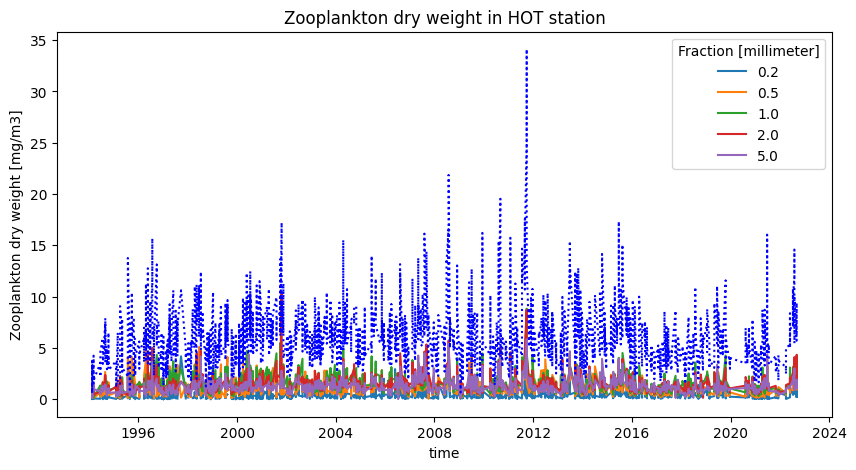

In [123]:
plt.figure(figsize=(10, 5))
(hot_ds["zooplankton_dry_weight"] / hot_ds["net_depth"]).plot.line(x="time", hue="frac")
(hot_ds["zooplankton_dry_weight_all_sized"] / hot_ds["net_depth"].mean("frac")).plot.line("b:", x="time")
plt.title("Zooplankton dry weight in HOT station")
plt.ylabel("Zooplankton dry weight [mg/m3]")
plt.show()

In [124]:
night_condition = (hot_ds.time.dt.hour > 18) | (hot_ds.time.dt.hour < 6)
hot_ds["is_night"] = xr.where(night_condition, True, False)
hot_ds = hot_ds.set_coords("is_night")
hot_ds.is_night.attrs = {
    "flag_values": f"{[True, False]}",
    "flag_meanings": "night day",
    "standard_name": "is_night",
    "long_name": "Is night",
}
hot_ds

<xarray.Dataset> Size: 150kB
Dimensions:                           (time: 1541, frac: 5)
Coordinates:
  * time                              (time) datetime64[ns] 12kB 1994-02-17T1...
  * frac                              (frac) float64 40B 0.2 0.5 1.0 2.0 5.0
    is_night                          (time) bool 2kB False False ... False True
Data variables:
    zooplankton_dry_weight            (time, frac) float64 62kB 13.2 ... 315.1
    net_depth                         (time, frac) float64 62kB 181.0 ... 241.0
    zooplankton_dry_weight_all_sized  (time) float64 12kB 145.5 ... 1.545e+03

In [125]:
zoo_m3 = hot_ds["zooplankton_dry_weight_all_sized"] / hot_ds["net_depth"].mean("frac")
data = [
    zoo_m3[hot_ds.is_night].expand_dims({"day_phase": ["night"]}),
    zoo_m3[~hot_ds.is_night].expand_dims({"day_phase": ["day"]}),
]
attrs = {
    "long_name": "Zooplankton dry weight",
    "standard_name": "zooplankton_dry_weight",
    "units": "mg/m3",
    "location": "HOT",
    "resampling": "monthly",
}
hot_zooplankton = xr.concat(data, dim="day_phase")
hot_zooplankton = hot_zooplankton.resample(time="1ME").mean().interpolate_na("time")
hot_zooplankton.attrs = attrs
hot_zooplankton

<xarray.DataArray (day_phase: 2, time: 344)> Size: 6kB
3.628 3.35 3.571 3.799 4.019 5.19 6.962 ... 2.888 4.05 5.252 5.866 6.5 7.12 7.72
Coordinates:
  * day_phase  (day_phase) object 16B 'night' 'day'
  * time       (time) datetime64[ns] 3kB 1994-02-28 1994-03-31 ... 2022-09-30
Attributes:
    long_name:      Zooplankton dry weight
    standard_name:  zooplankton_dry_weight
    units:          mg/m3
    location:       HOT
    resampling:     monthly

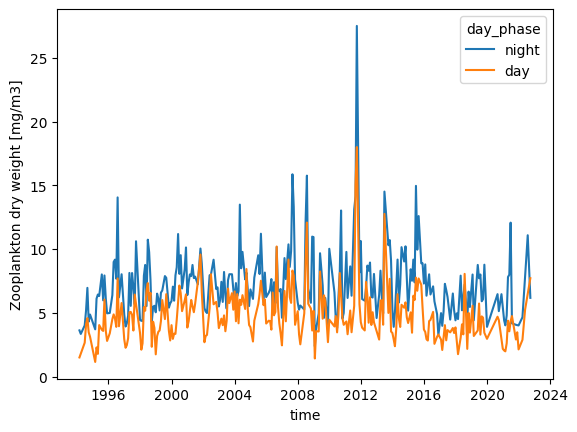

In [126]:
hot_zooplankton.plot.line(x="time")

# Migrant Zooplankton


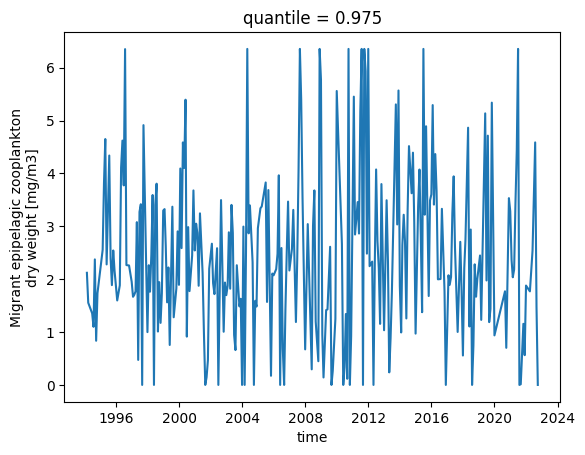

In [127]:
quantile = 0.975
zpk_migrant = hot_zooplankton.sel(day_phase="night") - hot_zooplankton.sel(day_phase="day")
zpk_migrant = zpk_migrant.resample(time="1ME").mean().interpolate_na("time")
outliers = zpk_migrant.quantile(quantile)
zpk_migrant = zpk_migrant.where(zpk_migrant > 0, 0).where(zpk_migrant < outliers, outliers)
zpk_migrant.attrs = {
    "long_name": "Migrant epipelagic zooplankton dry weight",
    "standard_name": "zooplankton_dry_weight",
    "units": "mg/m3",
    "interpolation": "linear",
    "resampling": "monthly",
    "ceil": "97.5 quantile",
    "lower threshold": "0",
    "location": "HOT",
}
zpk_migrant.plot()

# Zooplanlton epipelagic non-migrant


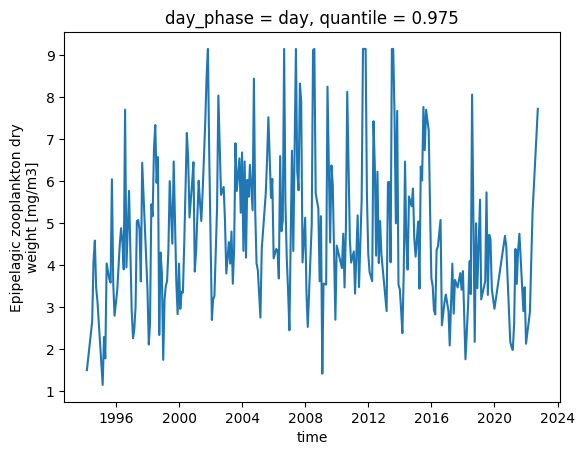

In [128]:
zooplankton_epi = hot_zooplankton.sel(day_phase="day").resample(time="1ME").mean().interpolate_na("time")
zooplankton_epi.name = "zooplankton_epi"
outliers = zooplankton_epi.quantile(quantile)
zooplankton_epi = xr.where(zooplankton_epi < 0, 0, zooplankton_epi)
zooplankton_epi = xr.where(zooplankton_epi > outliers, outliers, zooplankton_epi)
zooplankton_epi.attrs = {
    "long_name": "Epipelagic zooplankton dry weight",
    "standard_name": "zooplankton_dry_weight",
    "units": "mg/m3",
    "interpolation": "linear",
    "resampling": "monthly",
    "ceil": "97.5 quantile",
    "lower threshold": "0",
    "location": "HOT",
}
zooplankton_epi.plot()

---

# Add the layers limits


In [84]:
data_limits = copernicusmarine.open_dataset(
    dataset_id="cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-i",
    dataset_version="202211",
    minimum_latitude=22,
    maximum_latitude=23,
    minimum_longitude=-159,
    maximum_longitude=-158,
    start_datetime="1998-01-01",
    end_datetime="2021-07-17",
    variables=["pelagic_layer_depth"],
)
data_limits

INFO - 2024-04-30T01:51:27Z - You forced selection of dataset version "202211"
INFO - 2024-04-30T01:51:27Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-04-30T01:51:37Z - Service was not specified, the default one was selected: "arco-time-series"


<xarray.Dataset> Size: 35MB
Dimensions:              (depth: 3, latitude: 13, longitude: 13, time: 8599)
Coordinates:
  * depth                (depth) int32 12B 1 2 3
  * latitude             (latitude) float32 52B 22.0 22.08 22.17 ... 22.92 23.0
  * longitude            (longitude) float32 52B -159.0 -158.9 ... -158.1 -158.0
  * time                 (time) datetime64[ns] 69kB 1998-01-01 ... 2021-07-17
Data variables:
    pelagic_layer_depth  (time, depth, latitude, longitude) float64 35MB ...
Attributes:
    Conventions:                CF-1.7
    date_field:                 19980101
    domain:                     global
    history:                    Created on 2022-09-28
    institution:                CLS
    references:                 http://www.cls.fr; http://www.seapodym.eu
    source:                     SEAPODYM-LMTL 3.0.0
    source_physical_variables:  GLOBAL_REANALYSIS_PHY_001_030 CMEMS product
    spatial_resolution:         0.083x0.083
    temporal_resolution:        1 day
    title:                      Physical forcings of global ocean low and mid...

In [85]:
data_limits = data_limits.cf.sel(Y=slice(22.05, 22.2), X=slice(-158.2, -158.05))
data_limits = data_limits.cf.mean(dim=["X", "Y"])
data_limits

<xarray.Dataset> Size: 275kB
Dimensions:              (depth: 3, time: 8599)
Coordinates:
  * depth                (depth) int32 12B 1 2 3
  * time                 (time) datetime64[ns] 69kB 1998-01-01 ... 2021-07-17
Data variables:
    pelagic_layer_depth  (time, depth) float64 206kB 116.4 349.3 ... 422.7 986.3
Attributes:
    Conventions:                CF-1.7
    date_field:                 19980101
    domain:                     global
    history:                    Created on 2022-09-28
    institution:                CLS
    references:                 http://www.cls.fr; http://www.seapodym.eu
    source:                     SEAPODYM-LMTL 3.0.0
    source_physical_variables:  GLOBAL_REANALYSIS_PHY_001_030 CMEMS product
    spatial_resolution:         0.083x0.083
    temporal_resolution:        1 day
    title:                      Physical forcings of global ocean low and mid...

In [86]:
data_limits = data_limits.resample(time="1ME").mean().interpolate_na("time")
data_limits

<xarray.Dataset> Size: 9kB
Dimensions:              (depth: 3, time: 283)
Coordinates:
  * depth                (depth) int32 12B 1 2 3
  * time                 (time) datetime64[ns] 2kB 1998-01-31 ... 2021-07-31
Data variables:
    pelagic_layer_depth  (time, depth) float64 7kB 117.6 352.7 ... 423.3 980.4
Attributes:
    Conventions:                CF-1.7
    date_field:                 19980101
    domain:                     global
    history:                    Created on 2022-09-28
    institution:                CLS
    references:                 http://www.cls.fr; http://www.seapodym.eu
    source:                     SEAPODYM-LMTL 3.0.0
    source_physical_variables:  GLOBAL_REANALYSIS_PHY_001_030 CMEMS product
    spatial_resolution:         0.083x0.083
    temporal_resolution:        1 day
    title:                      Physical forcings of global ocean low and mid...

---

# Gathering data


In [132]:
final_ds = xr.Dataset(
    {
        "zooplankton_density": hot_zooplankton,
        "zooplankton_epi": zooplankton_epi,
        "zooplankton_migrant": zpk_migrant,
    }
)
final_ds = xr.merge([final_ds, data_limits]).expand_dims(
    {"latitude": new_latitude([hot_station_latitude]), "longitude": new_longitude([-hot_station_longitude])}
)
final_ds.latitude.attrs = new_latitude([hot_station_latitude]).attrs
final_ds.longitude.attrs = new_longitude([hot_station_longitude]).attrs
final_ds.time.attrs = new_time(final_ds.time.data).attrs
final_ds

<xarray.Dataset> Size: 22kB
Dimensions:              (latitude: 1, longitude: 1, day_phase: 2, time: 344,
                          depth: 3)
Coordinates:
  * latitude             (latitude) float64 8B 22.14
  * longitude            (longitude) float64 8B 158.1
  * day_phase            (day_phase) object 16B 'night' 'day'
  * time                 (time) datetime64[ns] 3kB 1994-02-28 ... 2022-09-30
    quantile             float64 8B 0.975
  * depth                (depth) int32 12B 1 2 3
Data variables:
    zooplankton_density  (latitude, longitude, day_phase, time) float64 6kB 3...
    zooplankton_epi      (latitude, longitude, time) float64 3kB 1.508 ... 7.72
    zooplankton_migrant  (latitude, longitude, time) float64 3kB 2.121 ... 0.0
    pelagic_layer_depth  (latitude, longitude, time, depth) float64 8kB nan ....

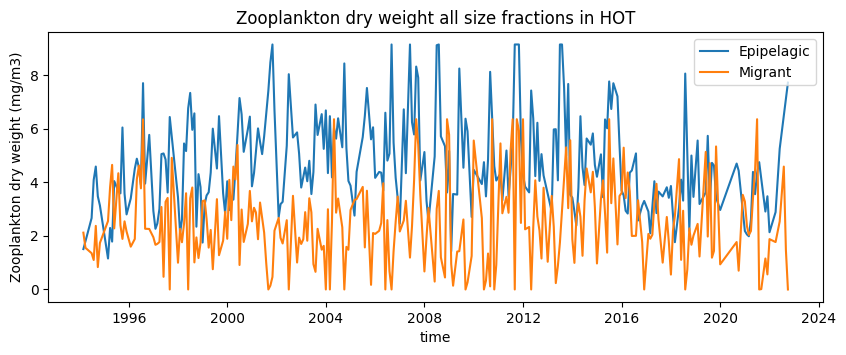

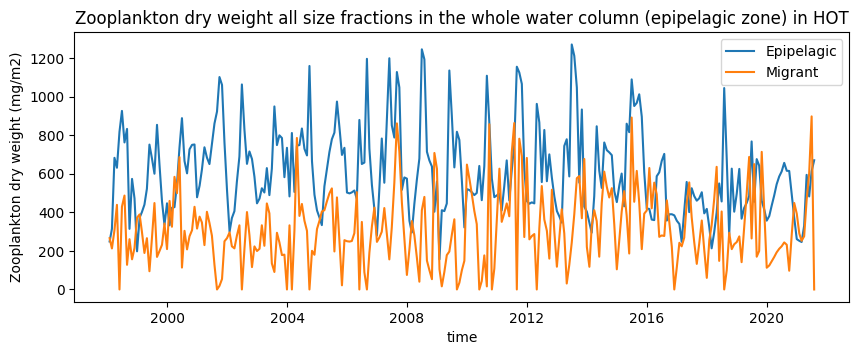

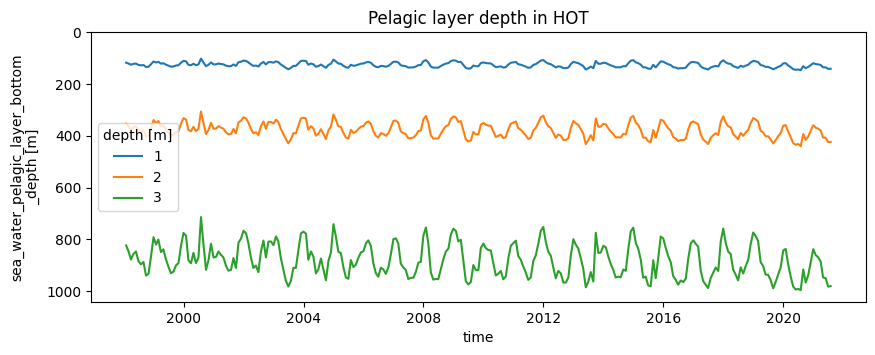

In [134]:
plt.figure(figsize=(10, 3.5))
final_ds["zooplankton_epi"].mean(["latitude", "longitude"]).dropna("time").plot(label="Epipelagic")
final_ds["zooplankton_migrant"].mean(["latitude", "longitude"]).dropna("time").plot(label="Migrant")
plt.ylabel("Zooplankton dry weight (mg/m3)")
plt.title("Zooplankton dry weight all size fractions in HOT")
plt.legend()
plt.show()

plt.figure(figsize=(10, 3.5))
(final_ds["zooplankton_epi"] * final_ds["pelagic_layer_depth"].sel(depth=1)).mean(["latitude", "longitude"]).dropna(
    "time"
).plot(label="Epipelagic")
(final_ds["zooplankton_migrant"] * final_ds["pelagic_layer_depth"].sel(depth=1)).mean(["latitude", "longitude"]).dropna(
    "time"
).plot(label="Migrant")
plt.title("Zooplankton dry weight all size fractions in the whole water column (epipelagic zone) in HOT")
plt.ylabel("Zooplankton dry weight (mg/m2)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 3.5))
ax = final_ds["pelagic_layer_depth"][0, 0, ...].dropna("time").plot.line(x="time")
plt.ylim(0, None)
plt.gca().invert_yaxis()
plt.title("Pelagic layer depth in HOT")
plt.show()

# Save the processed data


In [131]:
final_ds.to_netcdf("../data/phd/HOT/PROCESSED/HOT_zooplankton.nc", mode="w")